### Q2

In [1]:
import pandas as pd

# 讀取 CSV 文件
file_path = "HW3_text.csv"
df = pd.read_csv(file_path)

# 顯示前幾行數據來檢查內容
df.head()

,message,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative


#### top10 words
Decide the size of vocabulary (including emoji) and show top-10 of used-words.

In [2]:
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 完整的 emoji 正則表達式
# print("Original emoji pattern:", emoji_pattern) # 有括號
# print("Without brackets:", emoji_pattern[1:-1]) # 沒有括號
emoji_pattern = r'[\U0001F600-\U0001F64F' \
                r'\U0001F300-\U0001F5FF' \
                r'\U0001F680-\U0001F6FF' \
                r'\U0001F700-\U0001F77F' \
                r'\U0001F780-\U0001F7FF' \
                r'\U0001F800-\U0001F8FF' \
                r'\U0001F900-\U0001F9FF' \
                r'\U0001FA00-\U0001FA6F' \
                r'\U0001FA70-\U0001FAFF' \
                r'\U00002702-\U000027B0' \
                r'\U000024C2-\U0001F251' \
                r'\U0001F004-\U0001F0CF' \
                r'\U00002B50' \
                r'\U0001F004-\U0001F0CF' \
                r'\U00002700-\U000027BF' \
                r'\U0001F200-\U0001F251' \
                r'\U0001F004-\U0001F0CF' \
                r'\U0001F000-\U0001F02F' \
                r'\U0001F0A0-\U0001F0FF' \
                r'\U0001F600-\U0001F64F' \
                r'\U0001F300-\U0001F5FF' \
                r'\U0001F600-\U0001F64F]'

# 移除標點符號，方便之後以空白分割
def clean_text(text):
    text = text.lower()  # 轉小寫
    
    # 找出所有的表情符號
    emoji_matches = re.findall(emoji_pattern, text)
    
    # 替換原文本中的連續表情符號為帶空格的表情符號
    if len(emoji_matches) > 1:  # 如果找到的表情符號長度大於1，則需要分開
        for emoji_match in emoji_matches:
            # 拆分每個表情符號並在中間加入空格
            separated_emojis = emoji_match + " "
            # 替換原文本中的連續表情符號
            text = text.replace(emoji_match, separated_emojis)
    
    # 只保留字母、數字、空格、表情符號和單引號
    text = re.sub(r'[^a-zA-Z0-9\s\'' + emoji_pattern[1:-1] + ']', '', text)
    return text

# Clean the text data
df["cleaned_message"] = df["message"].astype(str).apply(clean_text)

# 計算詞頻
# Flatten the list of words from all messages
all_words = []
for message in df["cleaned_message"]:
    words = message.split()
    all_words.extend(words)

# Count words
word_counts = Counter(all_words)

# 詞彙表大小（含特殊字符和表情符號）
vocab_size = len(set(all_words))

# 前 10 個最常見單詞
top_10_words = word_counts.most_common(10)

# 生成詞雲
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

# 顯示結果
vocab_size, top_10_words

(843,
 [('the', 248),
  ("i'm", 213),
  ('i', 201),
  ('this', 171),
  ('was', 139),
  ('a', 101),
  ('is', 91),
  ('my', 91),
  ('to', 87),
  ('and', 64)])

#### word cloud
Generate a word cloud for these texts

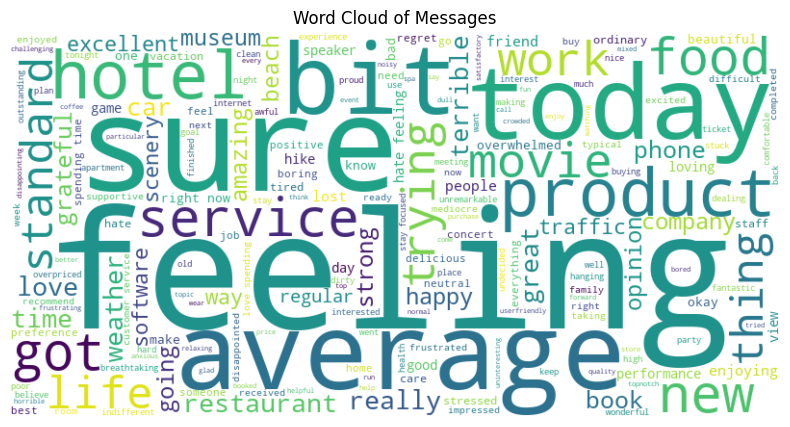

In [3]:
# 顯示詞雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # 隱藏座標軸
plt.title("Word Cloud of Messages")
plt.show()


#### Sentimental classification
Develop two models to classify these texts into one of the three possible sentiments.

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# 使用已有的 tokenizer 處理文本
from collections import Counter

# 創建 Dataset 和 DataLoader
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

In [17]:
# 設定參數
MAX_WORDS = 5000 
MAX_SEQ_LENGTH = 50  # 設定最大序列長度
EMBEDDING_DIM = 64  # 嵌入維度
HIDDEN_DIM = 128  # RNN 隱藏層維度
BATCH_SIZE = 16
NUM_LAYERS = 3  # RNN 層數

# 繼續使用已有的標籤映射
sentiment_labels = {"positive": 0, "neutral": 1, "negative": 2}
df["label"] = df["sentiment"].map(sentiment_labels)

# 建立詞彙表，限制為最常見的 MAX_WORDS 個單詞
word_counts = Counter(all_words)    # 統計list每個字出現的次數
vocab = ["<PAD>", "<OOV>"] + [word for word, count in word_counts.most_common(MAX_WORDS-2)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# 轉換文本為序列
def text_to_sequence(text, word_to_idx, max_length):
    # if the word is not in the dictionary, return 1 (OOV token)
    sequence = [word_to_idx.get(word, 1) for word in text.split()]  # 1 is OOV token
    # Pad sequence
    if len(sequence) < max_length:
        sequence += [0] * (max_length - len(sequence))  # 0 is PAD token
    else:
        sequence = sequence[:max_length]
    return sequence

# 將所有文本轉換為序列
X = np.array([text_to_sequence(text, word_to_idx, MAX_SEQ_LENGTH) for text in df["cleaned_message"]])
y = np.array(df["label"])

# 轉換為 PyTorch tensors
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

##### RNN

In [50]:
# 定義 RNN 模型
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()
        # size of dictionary to embed
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers = NUM_LAYERS, batch_first=True, bidirectional=True, dropout=0.2)
        # 2*hidden_dim because of bidirectional
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden) = self.rnn(embedded)
        output = self.fc(torch.mean(output, dim=1))  # (batch_size, num_classes)
        return output

In [ ]:
# 初始化模型
model = SentimentRNN(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 0.83], device=device))
learning_rate = 0.0003
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 訓練模型
epochs = 150

In [88]:
def training(epoch, train_loader, model, optimizer, criterion, save_name):
    """
    訓練模型的函數
    :param epoch: 訓練的輪數
    :param train_loader: 訓練數據的 DataLoader
    :param model: 要訓練的模型
    :param optimizer: 優化器
    :param criterion: 損失函數
    :param save_name: 保存模型的名稱
    """
    best_train_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        accuracy = 0.0
        total_loss = 0
        for i, batch in enumerate(train_loader):
            x_batch, y_batch = [t.to(device) for t in batch]
            
            optimizer.zero_grad()
            y_pred = model(x_batch) # (batch_size, num_classes)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            predicted = torch.argmax(y_pred, dim=1)
            accuracy += (predicted == y_batch).sum().item()

            total_loss += loss.item() * y_batch.size(0)  # 計算總損失
            # print(f'batch: {(i+1)*BATCH_SIZE}/{len(train_loader.dataset)}, batch_loss: {loss.item():.4f}')
        
        # Save weights
        if best_train_acc < accuracy / len(train_loader.dataset):
            best_train_acc = accuracy / len(train_loader.dataset)
            torch.save(model.state_dict(), save_name)

        print(f'Epoch: {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}, Accuracy: {accuracy/len(train_loader.dataset):.4f}')

In [78]:
training(epochs, train_loader, model, optimizer, criterion, 'SentimentalRNN.pth')

Epoch: 1, Loss: 0.0102, Accuracy: 0.9983
Epoch: 2, Loss: 0.0103, Accuracy: 0.9983
Epoch: 3, Loss: 0.0140, Accuracy: 0.9966
Epoch: 4, Loss: 0.1341, Accuracy: 0.9812
Epoch: 5, Loss: 1.1617, Accuracy: 0.7363
Epoch: 6, Loss: 0.3970, Accuracy: 0.7414
Epoch: 7, Loss: 0.3372, Accuracy: 0.7894
Epoch: 8, Loss: 0.2245, Accuracy: 0.9161
Epoch: 9, Loss: 0.1614, Accuracy: 0.9281
Epoch: 10, Loss: 0.1490, Accuracy: 0.9366
Epoch: 11, Loss: 0.1218, Accuracy: 0.9486
Epoch: 12, Loss: 0.1068, Accuracy: 0.9606
Epoch: 13, Loss: 0.1003, Accuracy: 0.9606
Epoch: 14, Loss: 0.0788, Accuracy: 0.9709
Epoch: 15, Loss: 0.0720, Accuracy: 0.9777
Epoch: 16, Loss: 0.0566, Accuracy: 0.9812
Epoch: 17, Loss: 0.2332, Accuracy: 0.9264
Epoch: 18, Loss: 0.3128, Accuracy: 0.8356
Epoch: 19, Loss: 0.1190, Accuracy: 0.9469
Epoch: 20, Loss: 0.0775, Accuracy: 0.9760
Epoch: 21, Loss: 0.1090, Accuracy: 0.9623
Epoch: 22, Loss: 0.0754, Accuracy: 0.9795
Epoch: 23, Loss: 0.0662, Accuracy: 0.9777
Epoch: 24, Loss: 0.0907, Accuracy: 0.9726
E

In [80]:
def evaluate(model, train_loader):
    # 評估模型
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in train_loader:
            x_batch, y_batch = [t.to(device) for t in batch]
            y_pred = model(x_batch)
            predicted = torch.argmax(y_pred, dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
        
    return np.array(all_labels), np.array(all_preds)

In [82]:
model = SentimentRNN(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 3).to(device)
model.load_state_dict(torch.load('SentimentalRNN.pth'))
all_labels, all_preds = evaluate(model, train_loader)

In [84]:
def show_confustion(all_labels, all_preds):
    # 顯示結果
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["positive", "neutral", "negative"]))

    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Classification Report:
              precision    recall  f1-score   support

    positive       1.00      1.00      1.00       178
     neutral       1.00      1.00      1.00       259
    negative       1.00      1.00      1.00       147

    accuracy                           1.00       584
   macro avg       1.00      1.00      1.00       584
weighted avg       1.00      1.00      1.00       584

Confusion Matrix:
[[178   0   0]
 [  0 259   0]
 [  0   0 147]]


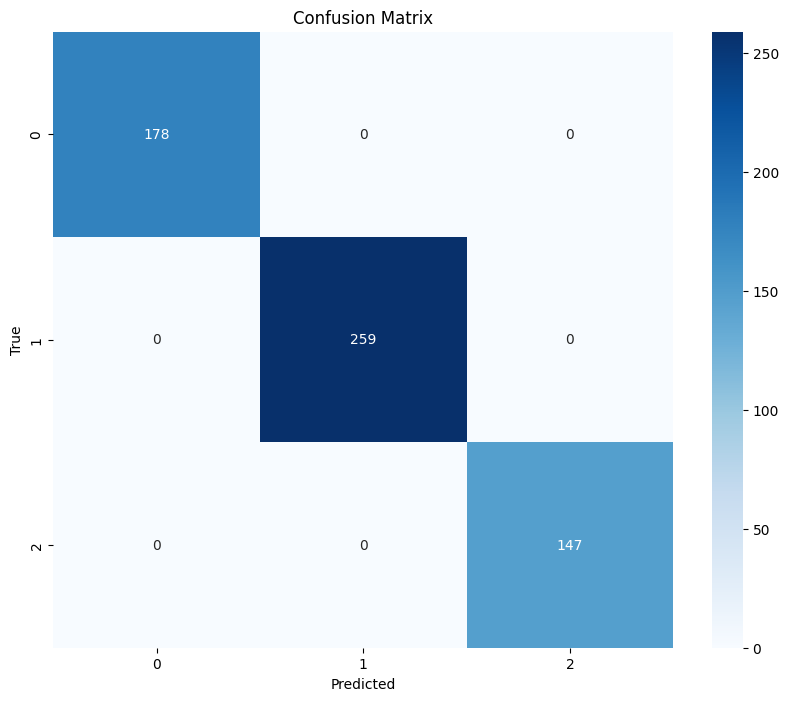

In [85]:
show_confustion(all_labels, all_preds)

##### LSTM

In [69]:
# 定義 LSTM 模型
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        # size of dictionary to embed
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, num_layers = NUM_LAYERS, batch_first=True, bidirectional=True, dropout=0.2)
        # 2*hidden_dim because of bidirectional
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, c_0) = self.LSTM(embedded)
        # average pooling
        output = self.fc(torch.mean(output, dim=1))  # (batch_size, num_classes)
        return output

In [90]:
# 初始化模型
model = SentimentLSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 3)
model = model.to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 0.83], device=device))
learning_rate = 0.0003
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 訓練模型
epochs = 60

training(epochs,train_loader, model, optimizer, criterion, 'SentimentalLSTM.pth')

Epoch: 1, Loss: 0.9495, Accuracy: 0.4401
Epoch: 2, Loss: 0.9214, Accuracy: 0.4435
Epoch: 3, Loss: 0.9140, Accuracy: 0.4435
Epoch: 4, Loss: 0.9057, Accuracy: 0.4435
Epoch: 5, Loss: 0.8593, Accuracy: 0.4658
Epoch: 6, Loss: 0.7283, Accuracy: 0.5651
Epoch: 7, Loss: 0.7008, Accuracy: 0.5702
Epoch: 8, Loss: 0.6051, Accuracy: 0.5959
Epoch: 9, Loss: 0.5368, Accuracy: 0.6370
Epoch: 10, Loss: 0.4977, Accuracy: 0.6558
Epoch: 11, Loss: 0.4376, Accuracy: 0.6884
Epoch: 12, Loss: 0.4099, Accuracy: 0.7106
Epoch: 13, Loss: 0.4662, Accuracy: 0.7072
Epoch: 14, Loss: 0.4080, Accuracy: 0.7175
Epoch: 15, Loss: 0.4003, Accuracy: 0.7123
Epoch: 16, Loss: 0.3573, Accuracy: 0.7380
Epoch: 17, Loss: 0.3403, Accuracy: 0.7483
Epoch: 18, Loss: 0.3863, Accuracy: 0.7277
Epoch: 19, Loss: 0.3514, Accuracy: 0.7329
Epoch: 20, Loss: 0.3265, Accuracy: 0.7414
Epoch: 21, Loss: 0.3136, Accuracy: 0.7568
Epoch: 22, Loss: 0.3069, Accuracy: 0.7414
Epoch: 23, Loss: 0.2963, Accuracy: 0.7757
Epoch: 24, Loss: 0.2911, Accuracy: 0.7603
E

In [91]:
model = SentimentLSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 3).to(device)
model.load_state_dict(torch.load('SentimentalLSTM.pth'))
all_labels, all_preds = evaluate(model, train_loader)


Classification Report:
              precision    recall  f1-score   support

    positive       1.00      0.98      0.99       178
     neutral       1.00      1.00      1.00       259
    negative       0.98      1.00      0.99       147

    accuracy                           0.99       584
   macro avg       0.99      0.99      0.99       584
weighted avg       0.99      0.99      0.99       584

Confusion Matrix:
[[175   0   3]
 [  0 259   0]
 [  0   0 147]]


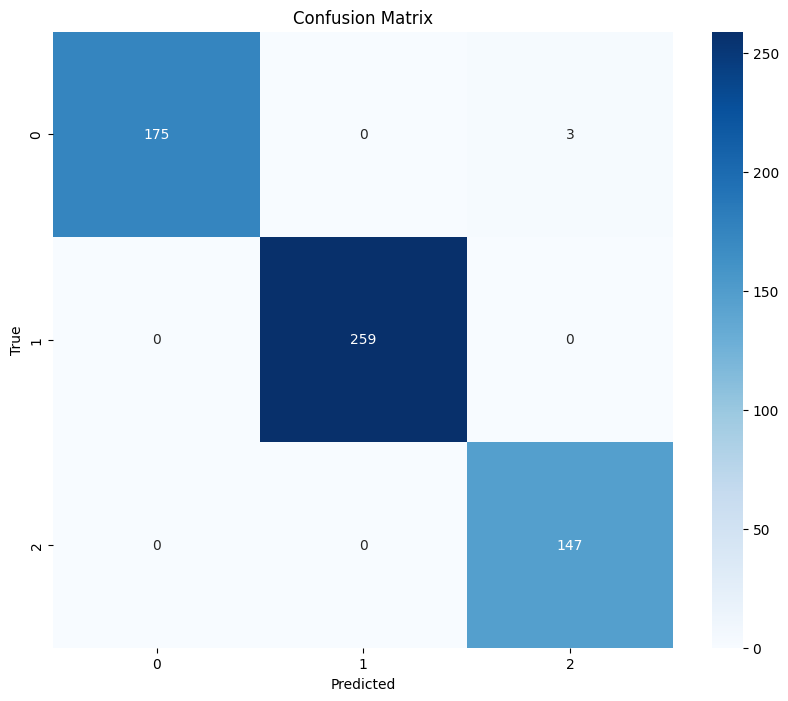

In [92]:
show_confustion(all_labels, all_preds)

#### Word prediction
reference link: 
1. [Next Word Prediction With LSTM (Pytorch)](https://www.kaggle.com/code/dota2player/next-word-prediction-with-lstm-pytorch)  
2. [Data Augmentation in NLP: Best Practices From a Kaggle Master](https://neptune.ai/blog/data-augmentation-nlp)

In [76]:
# 定義 Word Prediction LSTM 模型
# the last layer neurons numbers are the same as the vocabulary(dictionary) size
class WordPredictionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=3):
        super(WordPredictionLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, 
                           num_layers=num_layers, 
                           batch_first=True, 
                           bidirectional=True,
                           dropout=0.5,
                           )
        self.fc = nn.Linear(hidden_dim*2, vocab_size)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_length, hidden_dim)
        output = self.fc(lstm_out[:, -1, :])  # (batch_size, vocab_size)
        return output

By seening the previous sentence, predicting the most probable value.

In [7]:
# assume you have run the previous code to get all_words

# 建立詞彙表，限制為最常見的 MAX_WORDS 個單詞
MAX_WORDS = 5000 

# <START>：讓模型知道一個句子的開始，幫助模型學會「句子開頭可能出現哪些詞」。
# <END>：幫助模型預測何時該停止，尤其在生成文字的時候非常有用。

def build_vocab(tokenized_sentences, max_words=5000):
    word_counts = Counter(all_words)
    vocab = ["<PAD>", "<OOV>", "<START>", "<END>"] + [w for w, _ in word_counts.most_common(max_words - 4)]
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word

In [8]:
# divide token
tokenized_sentences = [sentence.split() for sentence in df["cleaned_message"]]
# apply build_vocab function
vocab, word_to_idx, idx_to_word = build_vocab(tokenized_sentences, max_words=MAX_WORDS)

In [9]:
print(tokenized_sentences[:5])

[['i', 'really', 'enjoyed', 'the', 'movie'], ['the', 'food', 'was', 'terrible'], ["i'm", 'not', 'sure', 'how', 'i', 'feel', 'about', 'this'], ['the', 'service', 'was', 'excellent'], ['i', 'had', 'a', 'bad', 'experience']]


ngram model

In [10]:
def generate_ngrams(tokenized_sentence):
    ngrams = []
    sentence = ["<START>"] + tokenized_sentence + ["<END>"]
    for i in range(1, len(sentence)):
        ngram = sentence[:i+1]
        ngrams.append(ngram)
    return ngrams

In [11]:
# Example ngrams
ngrams = generate_ngrams(["I", "love", "rabbits"])
print(ngrams)

[['<START>', 'I'], ['<START>', 'I', 'love'], ['<START>', 'I', 'love', 'rabbits'], ['<START>', 'I', 'love', 'rabbits', '<END>']]


In [107]:
def encode_ngram(ngram, word_to_idx):
    input_seq = [word_to_idx.get(word, word_to_idx["<OOV>"]) for word in ngram[:-1]]
    target = word_to_idx.get(ngram[-1], word_to_idx["<OOV>"])
    return input_seq, target

讓資料有變化

In [108]:
import random

# 🌟 功能：隨機把輸入中的詞換成 <oov>（10% 機率）
# 為什麼這樣做？
# 資料增強（data augmentation）
# 讓模型學會「即使遇到沒看過的詞，也要做出合理預測」
# 很像是「考試時遇到沒背過的單字，也要根據上下文猜意思」。

def add_oov_noise(ngram, prob=0.1):
    for i in range(len(ngram)-1):  # 最後一個是 target，不加 OOV
        if random.random() < prob:
            ngram[i] = "<OOV>"
    return ngram

In [109]:
test_ngram = ["the", "quick", "fox"]
input_seq, target = encode_ngram(test_ngram, word_to_idx)
# input_seq = ["the", "quick"], targer = "fox"
print(f"Input sequence: {input_seq}, Target: {target}")

Input sequence: [4, 1], Target: 1


In [ ]:
import nlpaug.augmenter.word as naw # NLP DataAugmentation library
import nltk
nltk.download('all') # necessary for WordNet -> averaged_perceptron_tagger_eng

In [110]:
# 功能：用同義詞替換 ngrams 中的詞
# 例如: ["Bella", "is", "smart"] -> ["Bella", "is", "intelligent"]
def Synonym_replace(ngrams):
    text = " ".join(ngrams)  # 將 ngrams 轉換為字符串
    aug = naw.SynonymAug(aug_src='wordnet')
    text_replaced = aug.augment(text)[0].split()  # 將替換後的文本轉換為列表
    return text_replaced

In [111]:
test_text = df['cleaned_message'][0].split()  # 取第一行的文本
print("Original text:", test_text)
augmented = Synonym_replace(test_text)  
print("Augmented text:", augmented) 
# 測試轉成encoded ngram
input_seq, target = encode_ngram(augmented, word_to_idx)
print(f"Input sequence: {input_seq}, Target: {target}") 

Original text: ['i', 'really', 'enjoyed', 'the', 'movie']
Augmented text: ['i', 'really', 'enjoy', 'the', 'motion', 'picture']
Input sequence: [6, 53, 270, 4, 1], Target: 1


Construct train dataset

In [77]:
def build_training_data_ngram(tokenized_sentences, word_to_idx, max_seq_len=5, add_noise=False, synonyms=False):
    X_data, y_data = [], []

    for sentence in tokenized_sentences: # get each sentence (tokenized)
        ngrams = generate_ngrams(sentence) # apply ngram function
        for ngram in ngrams:
            DataAug = [] # store for data augmentation
            DataAug.append(ngram) # add ngram to DataAug list
            if add_noise:
                noise_ngram = add_oov_noise(ngram)
                DataAug.append(noise_ngram)
            if synonyms:
                synonyms_ngram = Synonym_replace(ngram)
                DataAug.append(synonyms_ngram)

            for gram in DataAug:
                input_seq, target = encode_ngram(gram, word_to_idx)  # encode word to number

                # Padding
                if len(input_seq) < max_seq_len:
                    input_seq = [word_to_idx["<PAD>"]] * (max_seq_len - len(input_seq)) + input_seq
                else:
                    input_seq = input_seq[-max_seq_len:]

                X_data.append(input_seq)
                y_data.append(target)

    return torch.tensor(X_data), torch.tensor(y_data)

In [78]:
MAX_SEQ_LENGTH = 20
X, y = build_training_data_ngram(tokenized_sentences, word_to_idx, max_seq_len=MAX_SEQ_LENGTH, 
                                 add_noise=True, synonyms=False)

BATCH_SIZE = 64
# packed as pytorch dataloader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Model training

In [90]:
# 初始化模型
NUM_LAYERS = 2
EMBEDDING_DIM = 16  # 嵌入維度
HIDDEN_DIM = 128
TOPK = 3
model = WordPredictionLSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 訓練模型
epochs = 60

# 訓練模型
all_accuracies = []
all_losses = []
all_topk_accuracies = []
best_accuracy = 0.0
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    topk_predicted = 0
    total_samples = 0

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)  # shape: (batch_size, vocab_size)
        # y_pred = y_pred[:, -1, :]  # shape: (batch_size, vocab_size), selects the logits for the last position in the sequence
        loss = criterion(y_pred, y_batch)  # calculate loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)  # accumulate loss

        # 計算準確率
        predicted = torch.argmax(y_pred, dim=1)
        correct_predictions += (predicted == y_batch).sum().item()
        # 計算 Top-K 準確率
        _, topk_prediction = torch.topk(y_pred, TOPK, dim=1)
        topk_correct = torch.any(topk_prediction == y_batch.unsqueeze(1), dim=1).sum().item()
        topk_predicted += topk_correct

        total_samples += y_batch.size(0)

    # calculate accuracy
    accuracy = correct_predictions / total_samples
    topk_accuracy = topk_predicted / total_samples
    # append accuracy and loss to lists for later drawing
    all_accuracies.append(accuracy)
    all_losses.append(total_loss / len(train_loader.dataset))
    all_topk_accuracies.append(topk_accuracy)
    
    # save the model if accuracy is better than before
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'WordPredictionLSTM.pth')

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader.dataset):.4f}, Accuracy: {accuracy:.4f}, Top-{TOPK} Accuracy: {topk_accuracy:.4f}')

Epoch [1/60], Loss: 5.1591, Accuracy: 0.1436, Top-3 Accuracy: 0.2407
Epoch [2/60], Loss: 4.3349, Accuracy: 0.1996, Top-3 Accuracy: 0.3550
Epoch [3/60], Loss: 3.7908, Accuracy: 0.2455, Top-3 Accuracy: 0.4242
Epoch [4/60], Loss: 3.3935, Accuracy: 0.2801, Top-3 Accuracy: 0.4700
Epoch [5/60], Loss: 3.0773, Accuracy: 0.3024, Top-3 Accuracy: 0.5017
Epoch [6/60], Loss: 2.8146, Accuracy: 0.3243, Top-3 Accuracy: 0.5360
Epoch [7/60], Loss: 2.5871, Accuracy: 0.3516, Top-3 Accuracy: 0.5734
Epoch [8/60], Loss: 2.3777, Accuracy: 0.3848, Top-3 Accuracy: 0.6210
Epoch [9/60], Loss: 2.1831, Accuracy: 0.4165, Top-3 Accuracy: 0.6676
Epoch [10/60], Loss: 2.0212, Accuracy: 0.4490, Top-3 Accuracy: 0.7019
Epoch [11/60], Loss: 1.8736, Accuracy: 0.4807, Top-3 Accuracy: 0.7321
Epoch [12/60], Loss: 1.7363, Accuracy: 0.5084, Top-3 Accuracy: 0.7616
Epoch [13/60], Loss: 1.6104, Accuracy: 0.5413, Top-3 Accuracy: 0.7864
Epoch [14/60], Loss: 1.5109, Accuracy: 0.5663, Top-3 Accuracy: 0.8041
Epoch [15/60], Loss: 1.4181, 

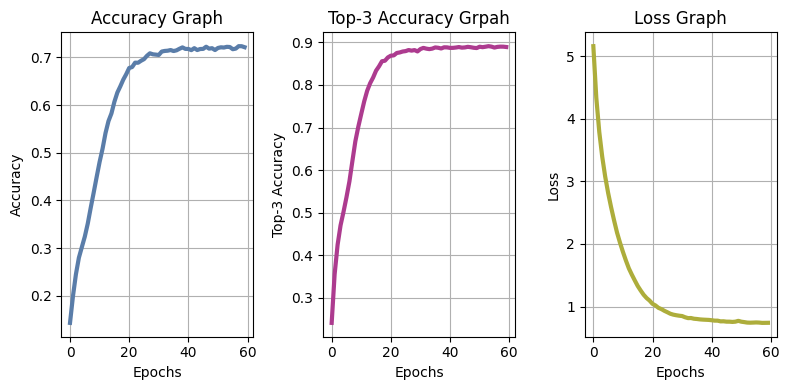

In [93]:
epoch_list = range(epochs)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4)) 

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)
 
axes[1].plot(epoch_list, all_topk_accuracies, color='#ad3b8f', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel(f'Top-{TOPK} Accuracy')
axes[1].set_title(f'Top-{TOPK} Accuracy Grpah')
axes[1].grid(True)

axes[2].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Loss')
axes[2].set_title('Loss Graph')
axes[2].grid(True)

plt.tight_layout()
plt.show()

Predict the remaining words of a sentence based on the initial words you input

In [96]:
def generate_text(model, start_seq, word_to_idx, idx_to_word, max_len=20):
    model.eval()
    generated = start_seq[:]
    for _ in range(max_len):
        seq_idx = [word_to_idx.get(w, word_to_idx["<OOV>"]) for w in generated]
        
        seq_tensor = torch.tensor(seq_idx).unsqueeze(0).to(device)  # shape: (1, seq_len)
        with torch.no_grad():
            output = model(seq_tensor)  # shape: (1, vocab_size)
            next_token_id = torch.argmax(output, dim=-1).item()  # Select the token's prediction
            next_token = idx_to_word[next_token_id]
        if next_token == "<END>":
            break
        generated.append(next_token)
    # Remove <START> from the generated sequence
    return " ".join(generated[1:])

In [106]:
# Load the trained model
word_prediction_model = WordPredictionLSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
word_prediction_model.load_state_dict(torch.load('WordPredictionLSTM.pth'))

# 隨機選擇一條消息
string = df["cleaned_message"].sample(n=1).values[0]
print(f"Original message: {string}")

# 將選擇的消息轉換為序列
start_seq = ["<START>"] + string.split()[:MAX_SEQ_LENGTH - 1]  # 確保序列長度不超過 MAX_SEQ_LENGTH

# 將選擇的消息截斷，當作測試資料
# 目標是預測出的文字能越接近原本的越好。
import random
endpoint = random.randrange(1, len(start_seq) - 1)
test_seq = start_seq[:endpoint]
print(f"Test sequence: {test_seq}")

# 生成文本
generated_text = generate_text(word_prediction_model, start_seq, word_to_idx, idx_to_word, max_len=MAX_SEQ_LENGTH)
print(f"Generated text: {generated_text}")

Original message: i need to call my insurance company to update my policy 📞 🤔 
Test sequence: ['<START>', 'i', 'need', 'to', 'call', 'my', 'insurance', 'company', 'to']
Generated text: i need to call my insurance company to update my policy 📞 🤔
